In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import copy

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_gaussian_quantiles
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

### Data Generation
Create only two features

In [3]:
x, y = make_gaussian_quantiles(cov=3.,
                               n_samples=10000, n_features=2,
                               n_classes=2, random_state=42)

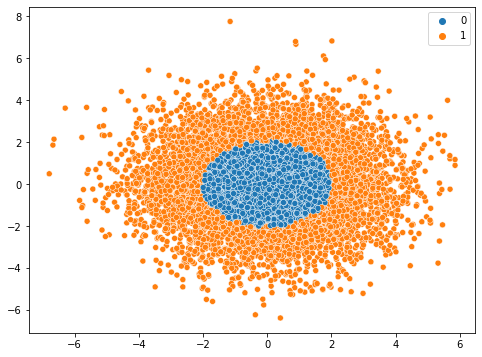

In [5]:
# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x[:,0], x[:,1], hue=y);

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

### Logistic Regression
let's find out how well logistic regression can cope with nonlinearly separable classes

In [6]:
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train)

LogisticRegression()

In [7]:
preds = log_reg_model.predict(x_train)
print('Train Accuracy: ', 1-np.mean(abs(preds-y_train)))

Train Accuracy:  0.522875


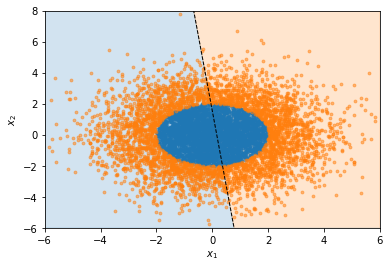

In [8]:
b = log_reg_model.intercept_[0]
w1, w2 = log_reg_model.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -6, 6
ymin, ymax = -6, 8
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*x_train[y_train==0].T, s=8, alpha=0.5)
plt.scatter(*x_train[y_train==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()

**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

<a name='4'></a>
### Neural Network model

Logistic regression didn't work well on the flower dataset. Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

### Forward Propagation

Let's implement `propagate_forward()` using the following equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$


**Instructions**:

- Check the mathematical representation of your classifier in the figure above.
- Use the function `sigmoid()`. It's built into (imported) this notebook.
- Use the function `np.tanh()`. It's part of the numpy library.
- Implement using these steps:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()` by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the backpropagation function.

### Backpropagation

Using the cache computed during forward propagation, you can now implement backward propagation.

Let's implement the function `propagate_back()`

<a name='4-6'></a>
### Update Parameters 

Let's implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.


**Hint**

- Use `copy.deepcopy(...)` when copying lists or dictionaries that are passed as parameters to functions. It avoids input parameters being modified within the function. In some scenarios, this could be inefficient, but it is required for grading purposes.

### Helper Functions 
For easier model implementation let's define some functions that will do some steps:
- `init_params()`
- `sigmoid()`
- `forward_propagation()`
- `compute_cost()`
- `propagate_back()`
- `update_params()`

In [81]:
# Parameters Initialization
def init_params(n_x, n_h, n_y, seed=42):
    
    np.random.seed(seed)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    B1 = np.zeros((n_h, 1))
    
    W2 = np.random.randn(n_y, n_h)*0.01
    B2 = np.zeros((n_y, 1))
    
    params = {'W1': W1, 'B1': B1, 'W2': W2, 'B2': B2}
    
    return params

# Activation Functions
    # Tanh: np.tanh 
    # Sigmoid: implement a function 

def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

# Forward Prop
def propagate_forward(X, parameters):
    """
    All computed parameters are useful, thus will be stored in a variable cache
    X must be transposed (n_features x n_observations)
    
    """
    
    Z1 = np.dot(parameters['W1'], X) + parameters['B1']
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(parameters['W2'], A1) + parameters['B2']
    A2 = sigmoid(Z2)
    
    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    
    return A2, cache

# Cost Computation
def compute_cost(Y_hat, Y):
    return - np.sum((Y*np.log(Y_hat) + (1 - Y)*np.log(1 - Y_hat)), axis=1, keepdims=True)/m

# Back Prop
def propagate_back(parameters, cache, X, Y):
    """X must be transposed (n_features x n_observations)"""
    m = X.shape[1]
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T)/m
    dB2 = np.sum(dZ2, axis=1, keepdims=True)/m
    
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T)/m
    dB1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    grads = {'dW1': dW1, 'dB1': dB1, 'dW2': dW2, 'dB2': dB2}
    
    return grads 

def update_params(parameters, grads, learning_rate = 1.2):
    
    # Params copying 
    W1 = copy.deepcopy(parameters['W1'])
    B1 = parameters['B1']
    W2 = copy.deepcopy(parameters['W2'])
    B2 = parameters['B2']
    
    # Gradients Copying 
    dW1 = copy.deepcopy(grads['dW1'])
    dB1 = grads['dB1']
    dW2 = copy.deepcopy(grads['dW2'])
    dB2 = grads['dB2']
    
    # Gradient Descent
    W1 = W1 - learning_rate*dW1
    B1 = B1 - learning_rate*dB1
    W2 = W2 - learning_rate*dW2
    B2 = B2 - learning_rate*dB2
    
    parameters = {"W1": W1, "B1": B1, "W2": W2, "B2": B2}
    
    return parameters

### nn_model

Build your neural network model using `nn_model()` function

**Instructions**: The neural network model has to use the previous functions in the right order

In [82]:
# Combine all previous functions 
def nn_model(X, Y, n_h, num_iterations=1000, learning_rate=1.2, return_cost=False, print_cost=False):
    
    """X must be transposed (n_features x n_observations)"""
    
    # Params Initialization
    nn_params = init_params(n_x=X.shape[0],
                            n_h=n_h,
                            n_y=1)
    
    costs = []
    
    # Forward Prop and GD step
    for cur_iter in range(0, num_iterations):
        A2, cache = propagate_forward(X=X, parameters=nn_params)
        current_cost = compute_cost(Y_hat=A2, Y=Y)
        current_grads = propagate_back(parameters=nn_params, cache=cache, X=X, Y=Y)
        nn_params = update_params(parameters=nn_params, grads=current_grads, learning_rate=learning_rate)
        
        # Save the current cost 
        costs.append(current_cost)
        
        if print_cost and cur_iter % 100 == 0:
            print(f'Iteration {cur_iter} Cost: {current_cost}')
        
    if return_cost:
        return nn_params, costs
                    
    return nn_params

# Predict method 
def predict(params, X, Y):
    A2, cache = propagate_forward(X=X, parameters=params)
    preds = np.where(A2 > 0.5, 1, 0)
    
    return preds

### Neural Net Training

In [83]:
learnt_params = nn_model(X=x_train.T, Y=y_train, n_h=5,
                         num_iterations=1500, learning_rate=1.5, print_cost=True, return_cost=False)

preds = predict(params=learnt_params, X=x_train.T, Y=y_train)
print('Train Accuracy: ', 1 - np.mean(np.abs(preds - y_train)))

Iteration 0 Cost: [[-573.81284212]]
Iteration 100 Cost: [[-573.79445583]]
Iteration 200 Cost: [[-573.35698913]]
Iteration 300 Cost: [[-316.79993787]]
Iteration 400 Cost: [[-163.35570773]]
Iteration 500 Cost: [[-186.59845765]]
Iteration 600 Cost: [[-174.10382773]]
Iteration 700 Cost: [[-164.46104991]]
Iteration 800 Cost: [[-160.72092221]]
Iteration 900 Cost: [[-158.96860059]]
Iteration 1000 Cost: [[-157.9039955]]
Iteration 1100 Cost: [[-157.18458179]]
Iteration 1200 Cost: [[-156.67889486]]
Iteration 1300 Cost: [[-156.32089929]]
Iteration 1400 Cost: [[-156.07548913]]
Train Accuracy:  0.905375


In [74]:
learnt_params, costs = nn_model(X=x_train.T, Y=y_train, n_h=5,
                                num_iterations=1500, learning_rate=1.5, 
                                print_cost=False, return_cost=True)

### Defining number of hidden neurons

Train Accuracy n_hidden: 2 0.772625
Train Accuracy n_hidden: 5 0.917625
Train Accuracy n_hidden: 8 0.9715
Train Accuracy n_hidden: 10 0.942625
Train Accuracy n_hidden: 30 0.9815
Train Accuracy n_hidden: 50 0.954875


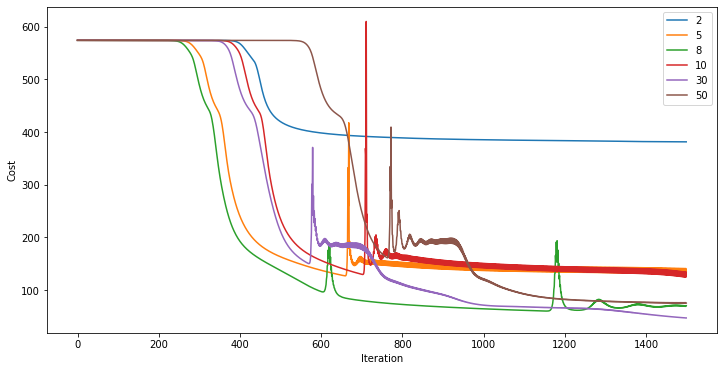

In [99]:
plt.figure(figsize=(12,6))
for n_hidden in [2, 5, 8, 10, 30, 50]:
    learnt_params, costs = nn_model(X=x_train.T, Y=y_train, n_h=n_hidden,
                                    num_iterations=1500, print_cost=False, learning_rate=1.2, return_cost=True)
    
    preds = predict(params=learnt_params, X=x_train.T, Y=y_train)
    print(f'Train Accuracy n_hidden: {n_hidden}', 1 - np.mean(np.abs(preds - y_train)))
    
    plt.plot(-np.squeeze(costs), label=n_hidden)

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend();

Probably the best number of hidden neurons 8. Also, it can be seen that `n_iters` can be set to 1300

### Defining Learning Rate

Train Accuracy l_rate: 1.2 0.9715
Train Accuracy l_rate: 0.001 0.505375
Train Accuracy l_rate: 1e-10 0.495
Train Accuracy l_rate: 3 0.931125
Train Accuracy l_rate: 5 0.955375


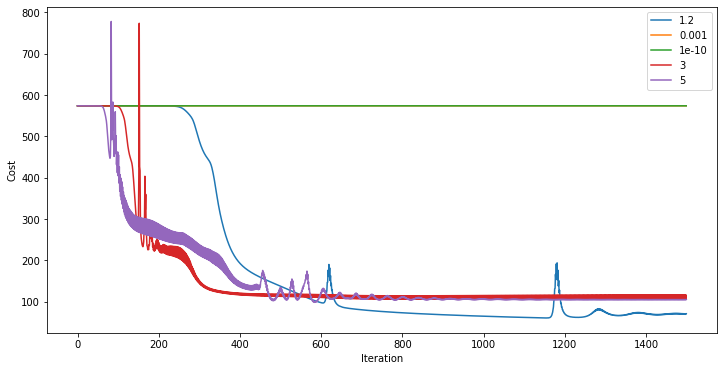

In [102]:
plt.figure(figsize=(12,6))
for l_rate in [1.2, 1e-3, 1e-10, 3, 5]:
    learnt_params, costs = nn_model(X=x_train.T, Y=y_train, n_h=8,
                                    num_iterations=1500, print_cost=False, learning_rate=l_rate, return_cost=True)
    
    preds = predict(params=learnt_params, X=x_train.T, Y=y_train)
    print(f'Train Accuracy l_rate: {l_rate}', 1 - np.mean(np.abs(preds - y_train)))
    
    plt.plot(-np.squeeze(costs), label=l_rate)

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend();

Can be seen that learning rate doesn't have to be too large

Train Accuracy l_rate: 0.2 0.54925
Train Accuracy l_rate: 0.5 0.981875
Train Accuracy l_rate: 1 0.97825


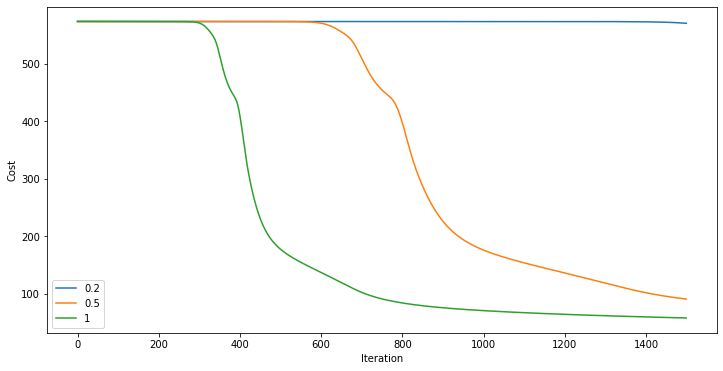

In [105]:
plt.figure(figsize=(12,6))
for l_rate in [0.2, 0.5, 1]:
    learnt_params, costs = nn_model(X=x_train.T, Y=y_train, n_h=8,
                                    num_iterations=1500, print_cost=False, learning_rate=l_rate, return_cost=True)
    
    preds = predict(params=learnt_params, X=x_train.T, Y=y_train)
    print(f'Train Accuracy l_rate: {l_rate}', 1 - np.mean(np.abs(preds - y_train)))
    
    plt.plot(-np.squeeze(costs), label=l_rate)

plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend();

Learning rate 0.5 is the best 

### Other Datasets
Built NN can be tested on other datasets:
- noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure